# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

-

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 229338 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
%load_ext autoreload
%autoreload 1
%aimport shared_functions
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
from functools import reduce
import sklearn
import shared_functions

## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
G = shared_functions.read_G(edges_csv_file, max_edges)

Using 229338 edges out of 229338 available (100.00% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [4]:
centrality_measures = shared_functions.centrality_measures(G)
print centrality_measures.keys()

['eigenvector_centrality', 'degree', 'betweenness_centrality']


#### Has link with node 1?

In [5]:
centrality_measures['has_link_to_node_1'] = shared_functions.has_link_to_node(G, 1)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [6]:
df = pd.read_csv(nodes_csv_file)

In [7]:
df = shared_functions.add_sha256_column_from_id(df)
df = shared_functions.merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [8]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory'
]

numeric_features = [
    'degree',
    'eigenvector_centrality',
    'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = shared_functions.prepare_data(df, numeric_features)

### Remove nodes without price and outliers

In [9]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [10]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'sha256_id', u'has_link_to_node_1',
       u'eigenvector_centrality', u'degree', u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [11]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,rating,width,height,depth,weight,sha256_id,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
count,9153.000000,9153,9153,9152,9035,9052,0.0,783,8820,8707,...,9153.000000,9153.000000,9153.000000,9153.000000,9153.000000,9.153000e+03,9153.000000,9.153000e+03,9153.000000,9153.000000
unique,NaN,8952,9153,6177,11,728,NaN,574,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/8580332990/,Vários Autores (Autor),Capa comum,Companhia das Letras,NaN,1 de janeiro de 2014,Livros,Livros,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6,1,106,7729,536,NaN,13,8820,8707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4896.658473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.443767,15.276002,22.264502,2.077165,425.828030,2.122251e+09,0.002076,3.406945e-03,31.259587,0.001066
std,2826.520995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551851,2.574086,2.590565,1.208801,201.984523,1.240653e+09,0.045516,9.780235e-03,34.801327,0.001544
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.800000,8.600000,0.200000,4.500000,2.291770e+05,0.000000,6.734553e-11,1.000000,0.000000
25%,2481.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.400000,13.600000,20.800000,1.300000,281.000000,1.025729e+09,0.000000,1.755986e-05,8.000000,0.000204
50%,4900.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.445241,15.304075,22.600000,1.800000,426.421903,2.113182e+09,0.000000,2.125446e-04,19.000000,0.000577
75%,7348.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.800000,16.000000,23.200000,2.600000,535.000000,3.182206e+09,0.000000,1.596866e-03,43.000000,0.001329


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [12]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,rating,width,height,depth,weight,sha256_id,has_link_to_node_1,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,...,4.000000,14.0,21.0,0.6,181.0,3564330554,0,2.295138e-05,19,0.001449
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,...,4.600000,14.6,21.0,1.9,363.0,1309098117,1,4.595498e-06,62,0.001143
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.445241,14.4,20.8,0.8,200.0,1260550007,1,5.866979e-06,59,0.002507
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.500000,13.7,21.5,1.6,381.0,4012708477,1,1.159003e-06,18,0.000698
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.500000,13.8,21.8,4.0,939.0,3891707921,0,8.827188e-06,88,0.002766
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,5.000000,13.8,21.5,2.2,581.0,2030201243,0,8.323662e-06,43,0.001477
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,...,4.445241,13.7,21.5,0.8,159.0,744636978,0,4.951852e-07,9,0.000193
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,...,5.000000,13.8,21.6,1.0,159.0,425205287,0,1.803160e-05,10,0.001264
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,...,4.445241,13.6,20.3,2.3,522.0,1246026773,0,1.837624e-06,23,0.000426
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,4.445241,14.0,20.3,1.3,159.0,1338518310,0,1.278774e-06,15,0.002428


## Random forest using multiple features, has_link_to_node_1 as target

### Preparing data

In [13]:
target, features, feature_list, validation_features, validation_target = shared_functions.prepare_datasets(df, numeric_features, categorical_features, 'has_link_to_node_1')

Numeric features:  ['degree', 'eigenvector_centrality', 'betweenness_centrality', 'ranking', 'reviewCount', 'pages', 'weight', 'height', 'width', 'depth', 'rating']
Categorical features:  ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10', 'language', 'coverType', 'publisher', 'rankingCategory']
Target column:  has_link_to_node_1
Test percentage:  0.200043701519
Train features shape:  (7322, 1833)
Train target shape:  (7322,)
Test features shape:  (1831, 1833)
Test target shape:  (1831,)


### Cross validation

#### Run cross val

In [14]:
estimators, splits, scores = shared_functions.run_cross_validation_classification(features, target)

#### Cross val confusion matrices

Splits quantity:  10
Splits lenghts:  [733, 733, 733, 733, 733, 732, 732, 731, 731, 731]
X shape:  (7322, 1833)
y shape:  (7322,)
Confusion matrix, without normalization


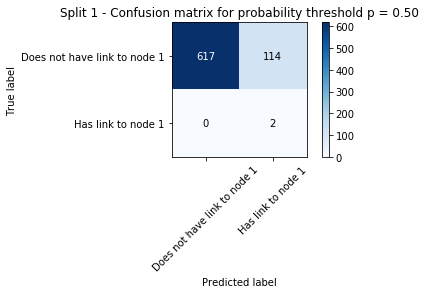

Confusion matrix, without normalization


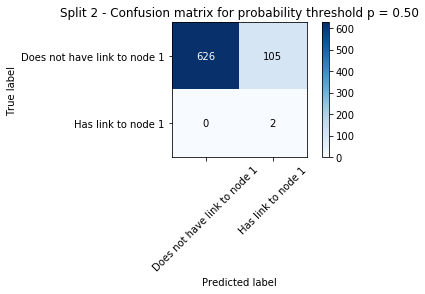

Confusion matrix, without normalization


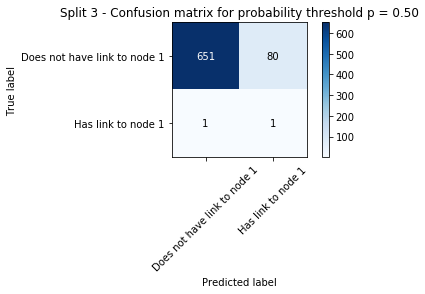

Confusion matrix, without normalization


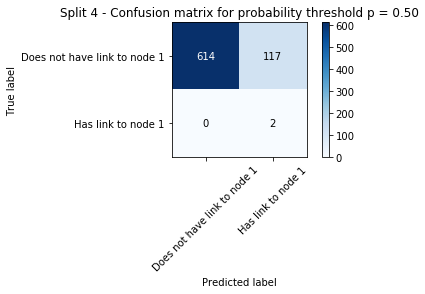

Confusion matrix, without normalization


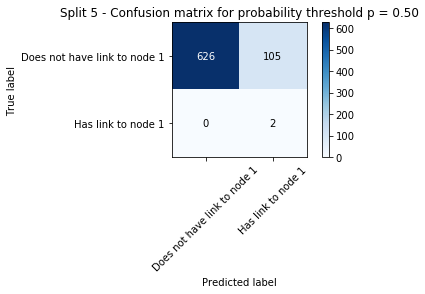

Confusion matrix, without normalization


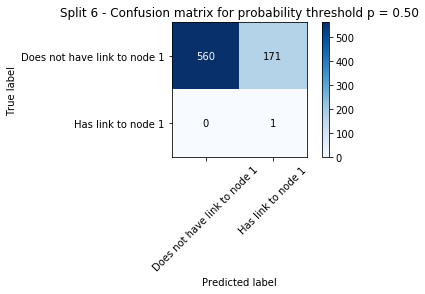

Confusion matrix, without normalization


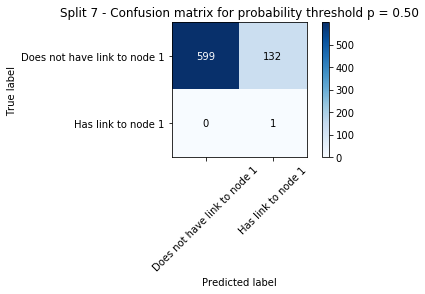

Confusion matrix, without normalization


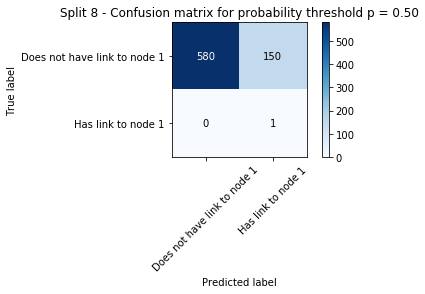

Confusion matrix, without normalization


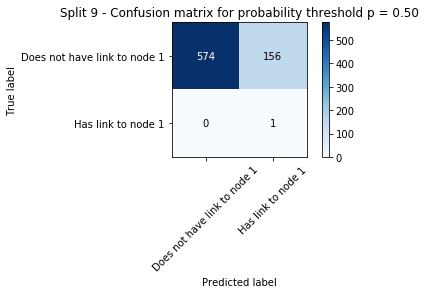

Confusion matrix, without normalization


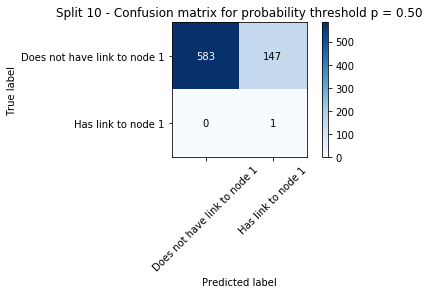

Normalized confusion matrix


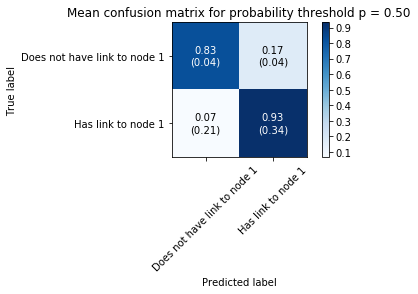

In [15]:
shared_functions.plot_splits_confusion_matrices(features, target, splits, estimators, threshold = 0.5)

#### List of most important features

In [16]:
shared_functions.get_most_important_features(estimators, feature_list)

,feature,mean importance,std,std/mean
0,degree,9.045785,1.726700,0.190884
1,ranking,8.480978,1.001842,0.118128
2,betweenness_centrality,8.029446,1.247764,0.155398
3,rating,7.986263,1.140162,0.142765
4,eigenvector_centrality,7.955341,1.583366,0.199032
5,reviewCount,5.479556,1.253471,0.228754
6,language_Português,5.341420,3.053442,0.571654
7,width,4.675161,0.819759,0.175343
8,language_Inglês,4.636645,1.428589,0.308108
9,sha256_id,4.041273,0.783993,0.193997


#### Predicted vs real

Splits quantity:  10
Splits lenghts:  [733, 733, 733, 733, 733, 732, 732, 731, 731, 731]
X shape:  (7322, 1833)
y shape:  (7322,)


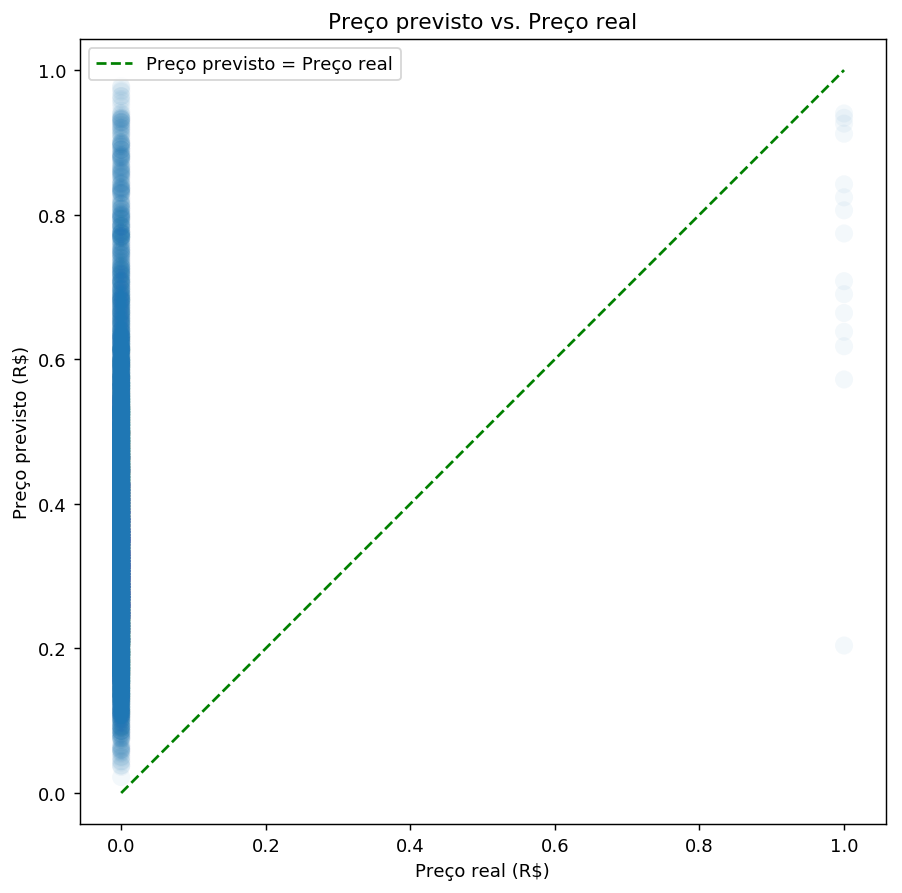

In [17]:
y_pred = shared_functions.get_all_predictions_from_splits(features, target, splits, estimators)                                                  
shared_functions.plot_splits_predicted_vs_real(target, y_pred)

#### Probability density

(7322,)


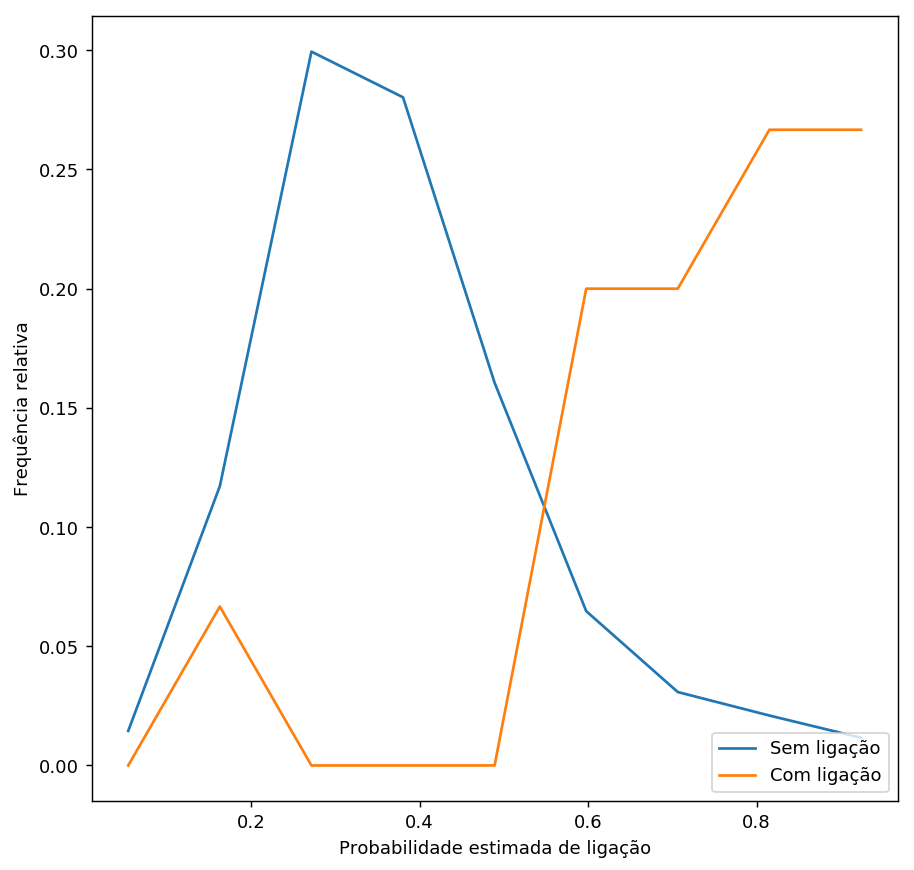

In [18]:
shared_functions.print_classification_probability_distribution(target, y_pred)

#### ROC Curve

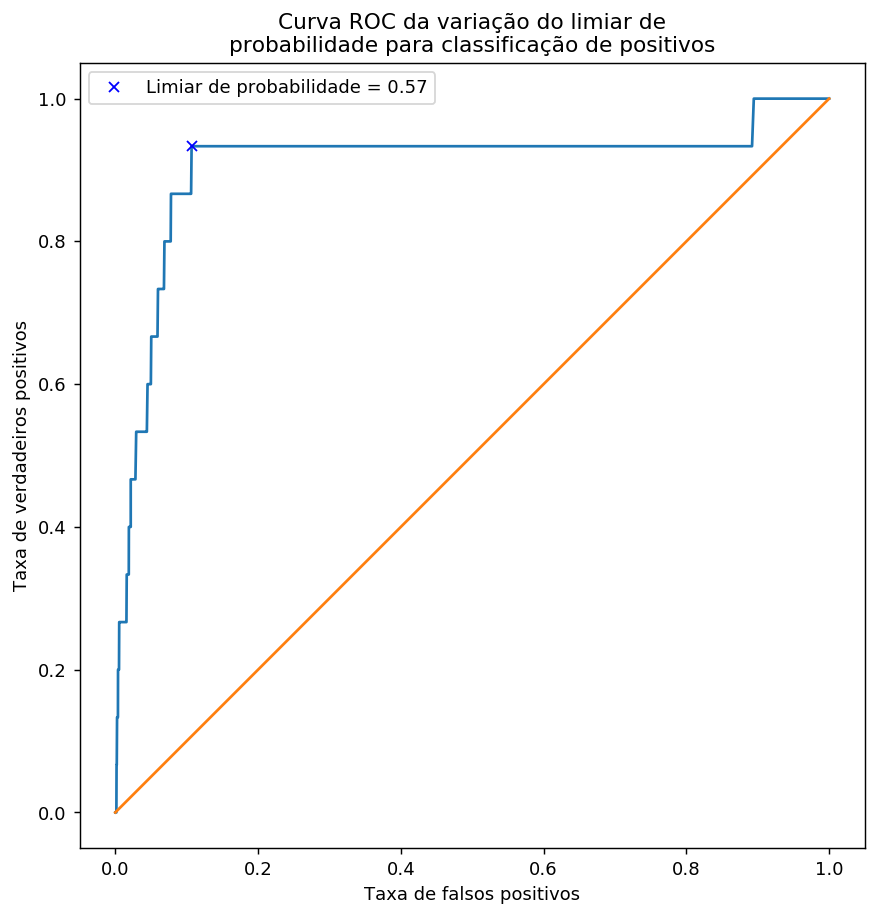

In [19]:
closest_to_optimal_probability = shared_functions.plot_roc_curve(target, y_pred)

Splits quantity:  10
Splits lenghts:  [733, 733, 733, 733, 733, 732, 732, 731, 731, 731]
X shape:  (7322, 1833)
y shape:  (7322,)
Confusion matrix, without normalization


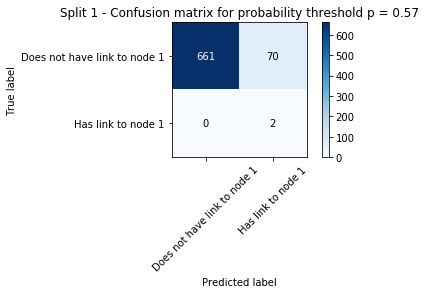

Confusion matrix, without normalization


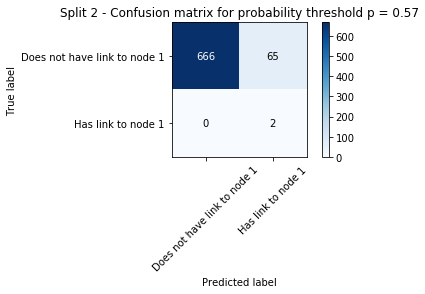

Confusion matrix, without normalization


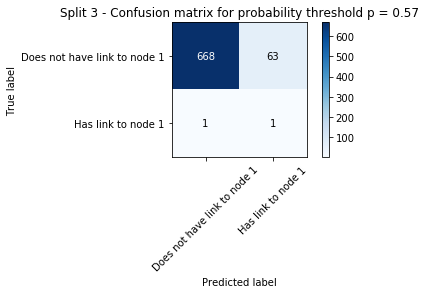

Confusion matrix, without normalization


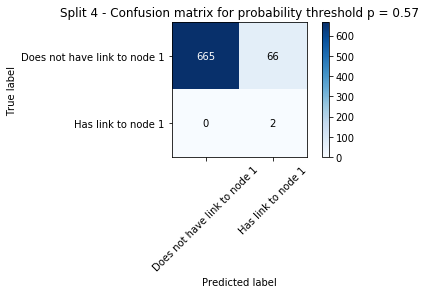

Confusion matrix, without normalization


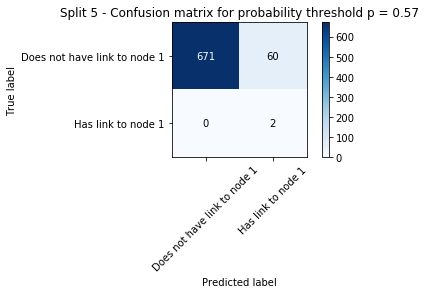

Confusion matrix, without normalization


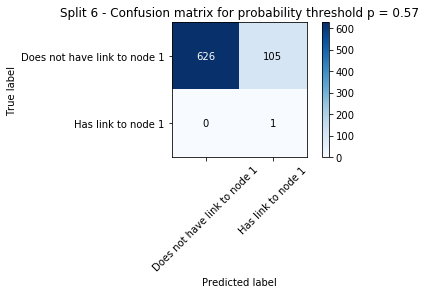

Confusion matrix, without normalization


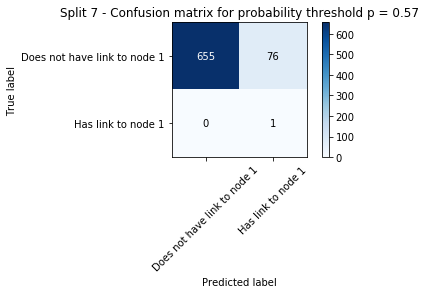

Confusion matrix, without normalization


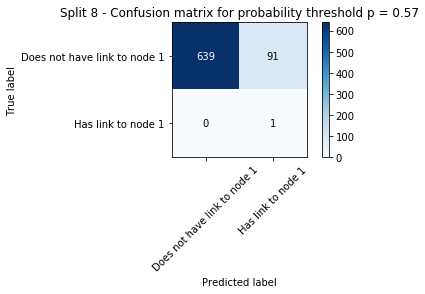

Confusion matrix, without normalization


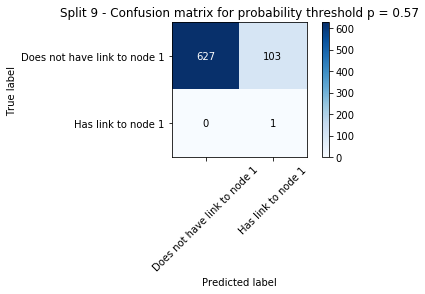

Confusion matrix, without normalization


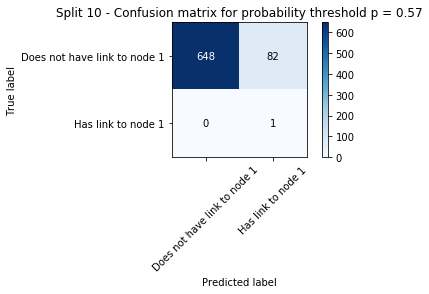

Normalized confusion matrix


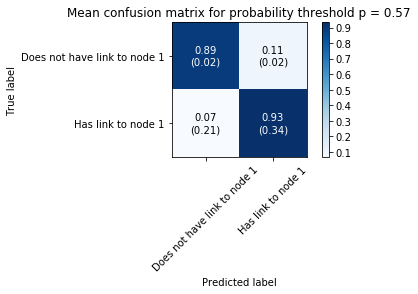

In [20]:
shared_functions.plot_splits_confusion_matrices(features, target, splits, estimators, threshold = closest_to_optimal_probability)

### Visualize decision tree

In [24]:
shared_functions.render_image_first_decision_tree(rf, feature_list, 'tree-link.png')

Output image:  tree-link.png


<img src="files/image.png">